<a href="https://colab.research.google.com/github/andidprastyo/ML-2023/blob/main/10%20-%20RNN/praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
def plot_graphs(history, metric):
	plt.plot(history.history[metric])
	plt.plot(history.history['val_'+metric], '')
	plt.xlabel("Epochs")
	plt.ylabel(metric)
	plt.legend([metric, 'val_'+metric])

### Load Dataset

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"This is one of the worst movies I have ever seen. However, the little slave girl, Alice and Jared Harris imitating Christopher Walken is what makes this movie entertaining. Alice's smoking, drinking and uncanny way of showing up when her name is called is strange and interesting. I have to applaud Jared for his Christopher Walken imitation, and Christopher Walken for allowing this to be in the movie."
 b'I had watched this film from Ralph Bakshi (Wizards, Hey Good Lookin\'), one night ago on www.afrovideo.org, and I didn\'t see anything racial (I am not stupid), I do admit the character designs are a bit crude and unaccpectable today, but I think it\'s a satire and a very,very urban retelling of the old Uncle Remus stories that the Black American culture, created right down to the main characters and the blatant nod to "The Tar Baby" and "The Briar Patch." These aren\'t bigoted stories, mind you, but cultural icons created by Black Americans, and me being a white woman read 

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [ 10,  67, 284, ...,   0,   0,   0],
       [  1,   7,   4, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is one of the worst movies I have ever seen. However, the little slave girl, Alice and Jared Harris imitating Christopher Walken is what makes this movie entertaining. Alice's smoking, drinking and uncanny way of showing up when her name is called is strange and interesting. I have to applaud Jared for his Christopher Walken imitation, and Christopher Walken for allowing this to be in the movie."
Round-trip:  this is one of the worst movies i have ever seen however the little [UNK] girl [UNK] and [UNK] [UNK] [UNK] [UNK] [UNK] is what makes this movie entertaining [UNK] [UNK] [UNK] and [UNK] way of showing up when her name is called is strange and interesting i have to [UNK] [UNK] for his [UNK] [UNK] [UNK] and [UNK] [UNK] for [UNK] this to be in the movie                                                                                                                                                                                                                          

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.00615536]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 116ms/step
[-0.00615536]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 47s 97ms/step - loss: 0.6267 - accuracy: 0.5857 - val_loss: 0.4627 - val_accuracy: 0.8010
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3894 - accuracy: 0.8206 - val_loss: 0.3869 - val_accuracy: 0.8474
Epoch 3/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3359 - accuracy: 0.8513 - val_loss: 0.3742 - val_accuracy: 0.8089
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3215 - accuracy: 0.8607 - val_loss: 0.3291 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3113 - accuracy: 0.8638 - val_loss: 0.3332 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3058 - accuracy: 0.8689 - val_loss: 0.3285 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3048 - accuracy: 0.8682 - val_loss: 0.3227 - val_accuracy:

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3186 - accuracy: 0.8621
Test Loss: 0.31862351298332214
Test Accuracy: 0.8621199727058411


In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-1.4419059]]


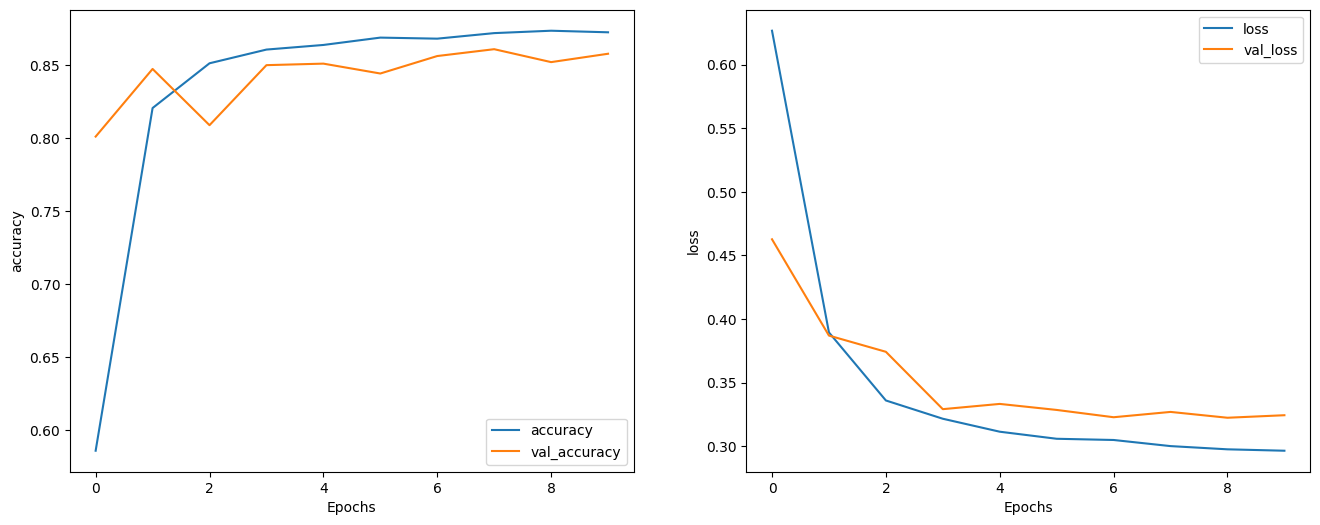

In [18]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')